## MSM estimation

Assuming our data was sampled in a time-correlated manner as it is the case for MD simulation data, we can use this clustering result as a basis for the estimation of a core-set Markov-state model.

In [37]:
from csmsm.estimator import CoresetMarkovStateModel

ModuleNotFoundError: No module named 'csmsm'

In [8]:
langerin = cluster.Clustering(
    np.load("md_example/langerin_projection.npy", allow_pickle=True),
    alias="C-type lectin langerin"
    )

In [9]:
langerin.labels = np.load("md_example/langerin_labels.npy")

In [11]:
M = CoresetMarkovStateModel(langerin.to_dtrajs(), unit="ns", step=1)

TypeError: __init__() got an unexpected keyword argument 'unit'

In [251]:
# Estimate csMSM for different lag times (given in steps)
lags = [1, 2, 4, 8, 15, 30]
for i in lags:
    M.cmsm(lag=i, minlenfactor=5, v=False)
    M.get_its()

[(0.0, 10459.606311240232)]

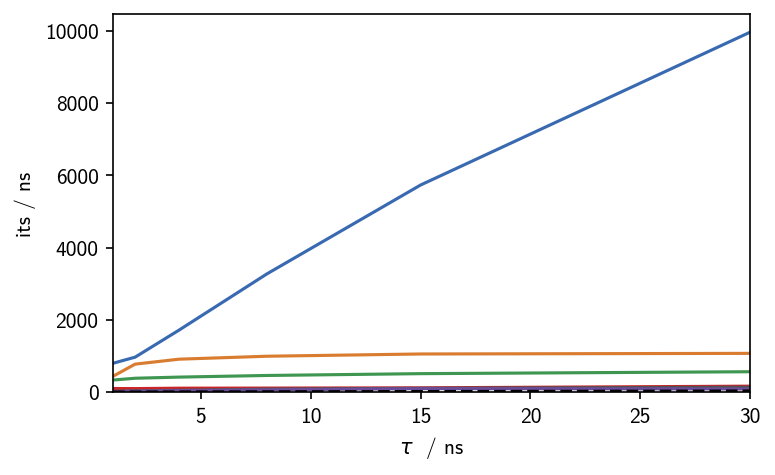

In [252]:
# Plot the time scales
fig, ax, *_ = M.plot_its()
fig.tight_layout(pad=0.1)
ax.set(**{
    "ylim": (0, None)
})

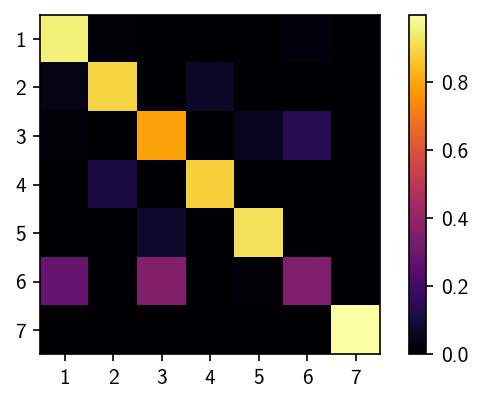

In [224]:
fig, ax = plt.subplots()
matrix = ax.imshow(M.T, cmap=mpl.cm.inferno)
fig.colorbar(matrix)
ax.set(**{
    "aspect": "equal",
    "xticks": range(len(M.T)),
    "xticklabels": range(1, len(M.T) + 1),
    "yticks": range(len(M.T)),
    "yticklabels": range(1, len(M.T) + 1)
})
plt.show()

## Prediction

In [134]:
# Lets make sure we work on the correctly clustered object
print("Label", "r", "c", sep="\t")
print("-" * 20)
for k, v in sorted(langerin_reduced.labels.info.params.items()):
    print(k, *v, sep="\t")

Label	r	c
--------------------
1	0.19	15
2	0.4	5
3	0.25	15
4	0.4	5
5	0.375	10
6	0.375	10
7	0.19	15
8	0.19	15
9	0.5	5
10	0.5	5
11	0.5	5
12	0.5	5
13	0.375	10
14	0.375	10
15	0.5	5
16	0.19	15
17	0.25	15


In [142]:
langerin_reduced_less = langerin.cut(points=(None, None, 50))

In [143]:
langerin_reduced_less.calc_dist(langerin_reduced, mmap=True, mmap_file="/home/janjoswig/tmp/tmp.npy", chunksize=1000)  # Distance map calculation

MemoryError: Unable to allocate 10.5 GiB for an array with shape (52942, 26528) and data type float64

## Cluster alternatives

It is always recommended to cross validate a clustering result with the outcome of other clustering approaches. We want to have a quick look at the alternative that density-peak clustering provides.

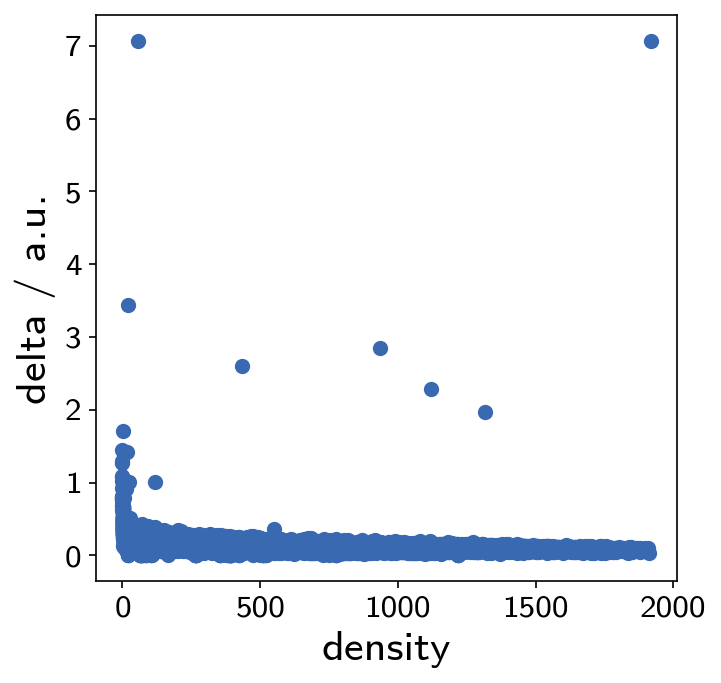

In [61]:
pydpc_clustering = pydpc.Cluster(langerin_reduced.data.points)

Clustering in this case is just a single step without the need of parameter specification. In the following, however, we need to extract the actual clusters by looking at the plot below. Points that are clearly isolated in this plot are highly reliable cluster centers.

In [65]:
pydpc_clustering.autoplot = True

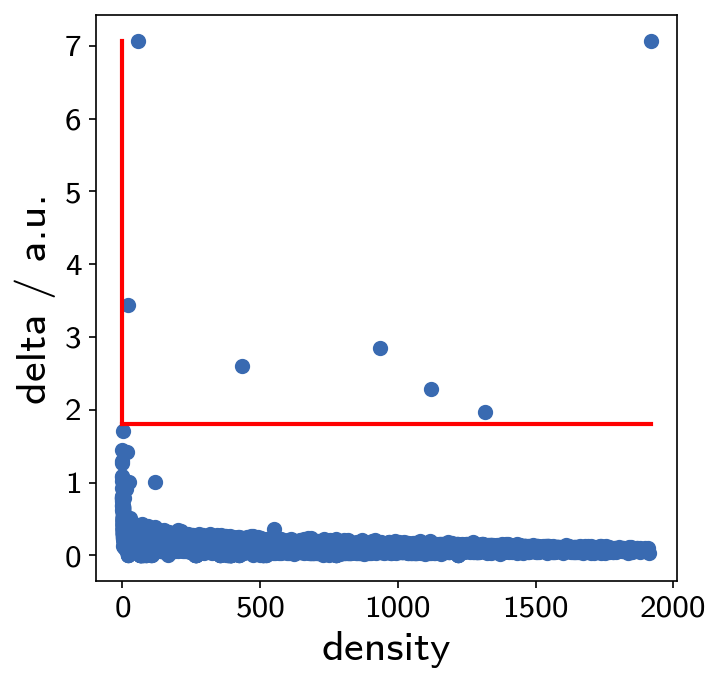

In [66]:
pydpc_clustering.assign(0, 1.8)

This gives us 7 clusters.

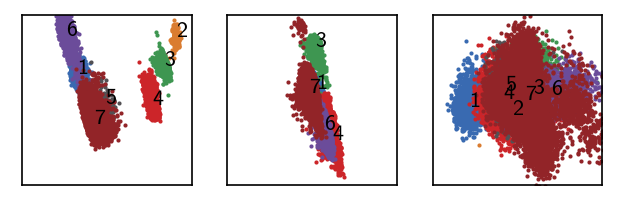

In [70]:
langerin_reduced.labels = (pydpc_clustering.membership + 1)
draw_evaluate(langerin_reduced)

As we are interested in core clusters we want to apply the core/halo criterion to disregard points with low cluster membership probabilitie as noise.

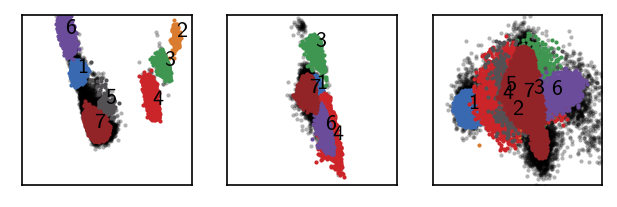

In [71]:
langerin_reduced.labels[pydpc_clustering.halo_idx] = 0
draw_evaluate(langerin_reduced)

In [72]:
M = cmsm.CMSM(langerin_reduced.get_dtraj(), unit="ns", step=1)

In [73]:
# Estimate csMSM for different lag times (given in steps)
lags = [1, 2, 4, 8, 15, 30]
for i in lags:
    M.cmsm(lag=i, minlenfactor=5)
    M.get_its()


*********************************************************
---------------------------------------------------------
Computing coreset MSM at lagtime 1 ns
---------------------------------------------------------

Using 116 trajectories with 25900 steps over 7 coresets

All sets are connected
---------------------------------------------------------
*********************************************************


*********************************************************
---------------------------------------------------------
Computing coreset MSM at lagtime 2 ns
---------------------------------------------------------

Using 116 trajectories with 25900 steps over 7 coresets

All sets are connected
---------------------------------------------------------
*********************************************************


*********************************************************
---------------------------------------------------------
Computing coreset MSM at lagtime 4 ns
-----------------------

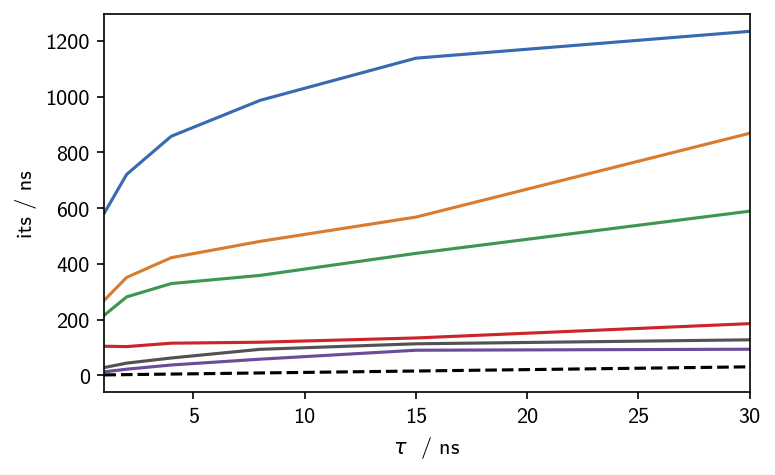

In [74]:
# Plot the time scales
fig, ax, *_ = M.plot_its()
fig.tight_layout(pad=0.1)

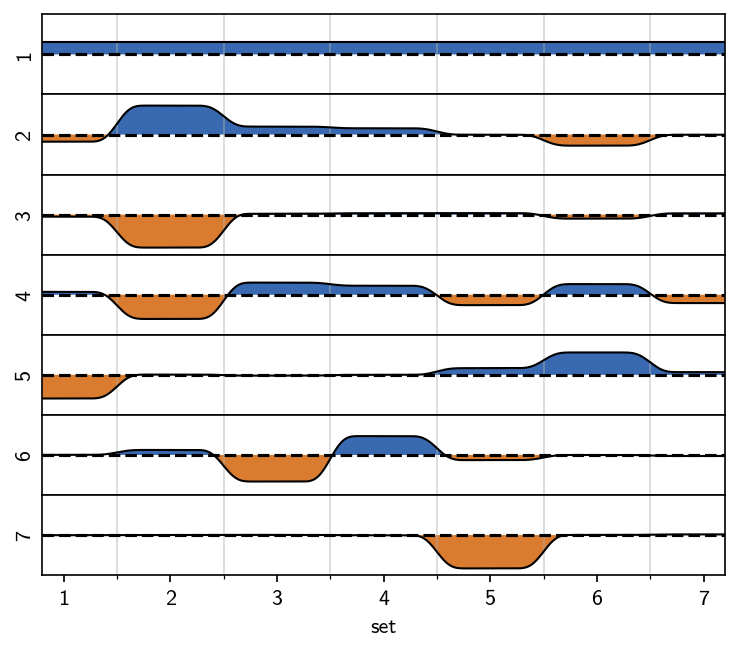

In [75]:
figsize = mpl.rcParams["figure.figsize"]
mpl.rcParams["figure.figsize"] = figsize[0], figsize[1] * 0.2
M.plot_eigenvectors()
mpl.rcParams["figure.figsize"] = figsize

This result is in good agreement with the one we obtained manually and argualbe faster and easier to achieve. If we decide that this result is exactly what we consider valid, then this is nice. If we on the other hand want to tune the clustering result further, with respect to splitting, noise level and what is considered noise in the first place we gain more flexibility with the manual approach.